L'objectif de ce projet est de créer un modèle de machine learning capable de déterminer la lettre présentée sur une image. Nous allons utiliser un réseau de neurones convolutif (CNN) pour résoudre ce problème. Pour cela, nous avons a disposition un jeu de données 'notMNIST' qui contient 10 dossiers pour 10 classes de lettres (A à J) à prédire. Le modèle sera entraîné pour reconnaitre uniquement les lettres allant de A à J. Pour chaque lettre, nous disposons de 1872 images, que l'on répartira entre les données d'entraînement, de validation et de test. Les images ont une taille de 28x28 pixels et sont en niveau de gris (1 canal).

Pour estimer la performance du modèle, nous utiliserons la précision (accuracy) comme métrique. La précision est le nombre de prédictions correctes divisé par le nombre total de prédictions. Elle est utilisée pour les problèmes de classification où le nombre de classes est équilibré. Dans notre cas, nous avons 10 classes et la répartition est la même entre ces 10 classes. Nous sommes également sesibles à la fonction de perte (loss) qui correspond à l'écart entre les prévisions du modèle et les observations réelles. Le but est de minimiser cette fonction de perte.

Pour le chargement des données, la construction du modèle, son entraînement, l'évaluation des résultats et l'affichage graphique des résultats, nous utilisons différentes librairies Python. Nous utlisons la librairie matplotlib pour le chargement des images et l'affichage de courbes de résultat. Keras et TensorFlow permettent la construction du modèle en différentes couches, l'entraînement et l'évaluation des résultats. Nous utilisons également la librairie numpy pour la manipulation des données, sklearn pour créer la matrice de confusion et les librairies glob et os pour la gestion des fichiers.

Nous avons également essayé d'effectuer du transfert learning en utilisant le modèle pré-entraîné MobileNetV2. Il est plus léger que VGG16, mais nous devons tout de même ruser pour lui fournir des images en 3 canaux alors que nous en avons qu'un seul. Au final le résultat satisfaisant, l'accurary est inférieure à celle obtenue avec le CNN.

### Prérerquis

Pour que le notebook fonctionne correctement, il faut que les librairies à importer soient installées. Il faut également se placer au même niveau que le dossier 'data' contenant le dossier 'notMNIST_small' qui contient les images à charger réparties en 10 dossiers (un par classe) portant le nom de la lettre correspondante.
Si vous souhaitez tenir compte des données augmentées (générées avec le script 'gan_data_augmentation.py'), il faut vous assurer que le dossier 'data' contient également le dossier 'notMNIST_small_augmented' qui contient les images générées réparties en 10 dossiers (un par classe) portant le nom de la lettre correspondante.

### Importation des librairies

In [32]:
import numpy as np
from tensorflow import keras
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
import visualkeras as vk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import glob
import os

# Preparation des données

In [142]:
# Paramètres du modèle / des données
img_width, img_height = 28, 28
epochs = 23
batch_size = 64
input_shape = (28, 28, 1)
num_classes = 10

La fonction 'get_images_letters_and_labels' permet de charger les images et les labels correspondants. Elle prend en paramètre le chemin vers le dossier contenant les images, le nombre d'exemples à attribuer au jeu de d'entrainement et de test. Nous prendrons ensuite une partie des données du jeu d'entrainement pour créer le jeu de validation. La fonction retourne les images et les labels correspondants pour les jeux d'entrainement et de test sous forme de tableau numpy. Les pixels des images sont compris entre 0 et 1. Les labels sont des entiers compris entre 0 et 9 en fonction de la classe de la lettre.

In [35]:
def get_images_letters_and_labels(data_path, nb_train_samples, nb_test_samples):
    # Initialiser des listes vides pour les données d'entraînement et de test ainsi que leurs labels
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    for letter in os.listdir(data_path):
        index = 0

        # Parcourir chaque fichier image dans le sous-répertoire de la lettre actuelle
        for image in glob.iglob(os.path.join(data_path, letter, "*.png")):

            # Vérifier si l'image actuelle doit faire partie de l'ensemble d'entraînement
            if index < nb_train_samples:
                pixels_array = mpimg.imread(image)  # Convertir l'image en tableau avec des valeurs entre 0 et 1
                x_train.append(pixels_array)
                y_train.append(ord(letter) - 65)   # Ajouter le label correspondant à la lettre actuelle
            # Vérifier si l'image actuelle doit faire partie de l'ensemble de test
            elif index < nb_train_samples + nb_test_samples: 
                pixels_array = mpimg.imread(image)  
                x_test.append(pixels_array)
                y_test.append(ord(letter) - 65)
            index += 1
            
    # Retourner les ensembles d'entraînement et de test ainsi que leurs labels
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

La fonction 'notMNIST_load_data' permet de charger le jeu de données. Le paramètre optionnel 'augmented' contient le chemin du dossier contenant les images générées pour augmenter le jeu de données initial. Pour chaque répertoire (initial et augmented), on vérifie que le nombre de dossiers (donc de lettres) correspond au nombre de classes que l'on veut prédire. On calcule le nombre d'exemples minimal pour chaque classe et on calcule le nombre d'exemples pour l'entrainement ou pour le test à partir de ce nombre. On dédie 80% des données pour l'enrainement et 20% pour le test. On récupère ensuite les images et les labels correspondants pour les jeux d'entrainement et de test et on les retourne.

In [36]:
def notMNIST_load_data(path_data_augmented=None) : 
    data_dir_letters = 'data/notMNIST_small'

    # Vérifier si le nombre de lettres dans le répertoire correspond au nombre de classes attendu
    nb_letters = len(os.listdir(data_dir_letters))
    if nb_letters != num_classes:
        raise ValueError('The number of classes is not equal to the number of letters in the folder')

   # 1. Obtenir les lettres à partir de l'ensemble de données d'origine

    # Obtenir le nombre d'échantillons dans la classe la plus petite
    min_nb_samples = float('inf')
    for letter in os.listdir(data_dir_letters):
        nb_samples = len(os.listdir(os.path.join(data_dir_letters, letter)))
        min_nb_samples = min(min_nb_samples, nb_samples)

    # 80 % des données sont utilisées pour l'entraînement, 20 % pour les tests
    nb_train_samples = int(min_nb_samples * 0.8)
    nb_test_samples = nb_samples - nb_train_samples

    # Obtenir les images et les labels pour chaque lettre
    x_train, y_train, x_test, y_test = get_images_letters_and_labels(data_dir_letters, nb_train_samples, nb_test_samples)


    # 2. Obtenir les lettres à partir des données d'augmentation si elles existent

    if path_data_augmented is not None:

        nb_letters_augmented = len(os.listdir(path_data_augmented))
        if nb_letters_augmented != num_classes:
            raise ValueError('The number of classes is not equal to the number of letters augmented in the folder')
        
        # Obtenir le nombre d'échantillons dans la classe la plus petite
        min_nb_samples = float('inf')
        for letter_augmented in os.listdir(path_data_augmented):
            nb_samples = len(os.listdir(os.path.join(path_data_augmented, letter_augmented)))
            min_nb_samples = min(min_nb_samples, nb_samples)

        # 80 % des données sont utilisées pour l'entraînement, 20 % pour les tests
        nb_train_samples = int(min_nb_samples * 0.8)
        nb_test_samples = nb_samples - nb_train_samples

        # Obtenir les images et les labels pour chaque lettre
        x_train_augmented, y_train_augmented, x_test_augmented, y_test_augmented = get_images_letters_and_labels(path_data_augmented, nb_train_samples, nb_test_samples)

        # Concaténer les deux ensembles de données
        x_train = np.concatenate((x_train, x_train_augmented))
        y_train = np.concatenate((y_train, y_train_augmented))
        x_test = np.concatenate((x_test, x_test_augmented))
        y_test = np.concatenate((y_test, y_test_augmented))
        
    # Retourner les ensembles d'entraînement et de test avec leurs labels
    return (x_train, y_train), (x_test, y_test)

### Chargement des données et répartition en jeu d'entraînement et de test

In [149]:
# Sans récupération des données augmentées :
(x_train, y_train), (x_test, y_test) = notMNIST_load_data()

# Avec récupération des données augmentées :
# (x_train, y_train), (x_test, y_test) = notMNIST_load_data('data/generated')

On vérifie que les images ont une forme de (28, 28, 1)

In [120]:
# Vérification de la taille et affichage du nombre d'échantillons
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (28020, 28, 28, 1)
28020 train samples
7020 test samples


On converti les vecteurs de classe en matrices de classe binaires

In [121]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Construction du modèle

Cette fonction utilise la classe Sequential de Keras pour construire un modèle. Nous nous sommes inspirés de l'architecture LeNet-5 pour construire le modèle et nous l'avons adapaté à la tâche de classification actuelle. On avons essayé plusieurs combinaisons de couches différentes avec des paramètres différentes (nombre de filtres, taille des filtres, taille des couches, etc.)

On commence par construire les couches basses du modèle (couches de convolution et pooling) pour extraire les caractérsitiques, puis les couches hautes qui permettent de classifier les images. Les couches de convolution sont utilisées pour extraire les caractéristiques des images. Les couches de pooling permettent de réduire la dimension des images et de réduire le nombre de paramètres du modèle. Avant la classification, on aplatit les données pour les passer dans des couches entièrement connectées. Des couches de dropout sont ajoutées entre certaines couches pour éviter le surajustement. Pour finir, la couche de sortie a un nombre d'unités égal au nombre de classes avec une activation softmax.

In [122]:
def build_model():
    model = Sequential()
    
    # Couches basses du modèle : extraction des caractéristiques

    # Ajout d'une couche de convolution avec 32 filtres, une taille de noyau de 5x5 et une activation ReLU
    # on spécifie la taille de l'entrée uniquement pour la première couche
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape))

    # Ajout d'une couche de pooling avec un filtre de 2x2
    model.add(MaxPooling2D(strides=2))

    # Ajout d'une couche de convolution avec 48 filtres cette fois, une taille de noyau de 5x5 et une activation ReLU
    model.add(Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu'))

    # Ajout d'une couche de pooling avec un filtre de 2x2
    model.add(MaxPooling2D(strides=2))

    # On applatit les données pour les faire passer à travers les couches entièrement connectées
    model.add(Flatten())  


    # Couches hautes du modèle : classification

    # Ajout d'une couche de dropout pour éviter le surajustement avec un taux d'extinction de 25%
    model.add(Dropout(rate=0.25))

    # Couche dense avec 256 unités et activation ReLU
    model.add(Dense(units=256, activation='relu'))

    # Ajout d'une couche de dropout pour éviter le surajustement avec un taux d'extinction de 50%
    model.add(Dropout(rate=0.5))

    # Couche dense avec 84 unités et activation ReLU
    model.add(Dense(units=84, activation='relu'))

    # Ajout d'une couche de dropout pour éviter le surajustement avec un taux d'extinction de 50%
    model.add(Dropout(rate=0.5))
    
    # Couche dense de sortie avec un nombre d'unités égal au nombre de classes et activation softmax
    model.add(Dense(units=num_classes, activation = 'softmax'))

    return model

On récupère le modèle et on affiche un résumé de l'architecture du modèle.

In [143]:
model = build_model()
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_77 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_47 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_78 (Conv2D)          (None, 14, 14, 48)        38448     
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 7, 7, 48)          0         
 ng2D)                                                           
                                                                 
 flatten_16 (Flatten)        (None, 2352)              0         
                                                                 
 dropout_42 (Dropout)        (None, 2352)            

### Visualisation schématique le modèle

Grâce à la librairie visualkeras, on peut afficher le modèle sous forme de schéma. Cela permet de se donner une idée de l'architecture du modèle et la taille des couches. Pour notre modèle, cela donne :

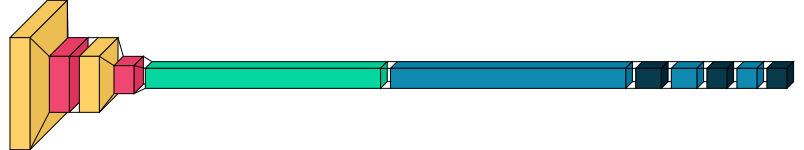

In [124]:
vk.layered_view(model)

# Entraînement du modèle

On peut maintenant passer à l'entraînement du modèle. On peut le faire sans validation croisée k-fold, et dans ce cas on n'ajoute pas de données de validation, ou avec. A ne pas confondre avec le cross-validation, dont le but est de déterminer les meilleurs hyperparamètres (nombre d'epoch, fonction d'activation, fonction coût, optimiser...), nous le but ici est uniquement de séparer le jeu d'entrainement en sous-ensembles et de combiner ces sous-ensembles pour entrainer plusieurs modèles. Cela nous permet de vérifier que l'accurary et le loss sont homogènes avec différents jeux de validation et de retourner le meilleur modèle.

## Sans la validation croisée k-fold

Compilation du modèle

In [103]:
model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy"]
)

Entraînement du modèle avec les paramètres spécifiés. On utilise du multi-processing pour accélérer l'entraînement.

In [104]:
history = model.fit(
    x_train,
    y_train,
    epochs=epochs, 
    batch_size=batch_size,
    steps_per_epoch=len(x_train) // batch_size,

    # Ces paramètres permettent d'activer le traitement parallèle/multithread :
    workers=16,
    use_multiprocessing=True
)

Epoch 1/20
233/233 [==============================] - 5s 17ms/step - loss: 0.8242 - accuracy: 0.7343
Epoch 2/20
233/233 [==============================] - 4s 17ms/step - loss: 0.3570 - accuracy: 0.8996
Epoch 3/20
233/233 [==============================] - 4s 17ms/step - loss: 0.2831 - accuracy: 0.9183
Epoch 4/20
233/233 [==============================] - 4s 17ms/step - loss: 0.2439 - accuracy: 0.9291
Epoch 5/20
233/233 [==============================] - 4s 17ms/step - loss: 0.2173 - accuracy: 0.9367
Epoch 6/20
233/233 [==============================] - 4s 17ms/step - loss: 0.1903 - accuracy: 0.9428
Epoch 7/20
233/233 [==============================] - 4s 17ms/step - loss: 0.1817 - accuracy: 0.9463
Epoch 8/20
233/233 [==============================] - 4s 17ms/step - loss: 0.1661 - accuracy: 0.9493
Epoch 9/20
233/233 [==============================] - 4s 17ms/step - loss: 0.1595 - accuracy: 0.9511
Epoch 10/20
233/233 [==============================] - 4s 17ms/step - loss: 0.1436 - accura

## Avec la validation croisée k-fold

Dans ce cas, on sépare le jeu d'entrainement en 5 sous-ensembles. On entraine 5 modèles avec chacun des sous-ensembles comme jeu de validation et le reste comme jeu d'entrainement. On retourne le meilleur modèle.

In [144]:
# Paramètres du k-fold
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

Cette fonction prend en paramètre le modèle à entrainer, le jeu d'entrainement et le jeu de test. Le jeu d'entrainement est alors séparé en sous-ensembles, on récupère les indices pour les différents folds. Pour chaque fold, on compile à nouveau le modèle, on entraine le modèle sur le sous-ensemble de données. On calcule l'accuarcy et le loss moyen, et on retourne le meilleur modèle (celui avec la meilleure accuracy).

In [145]:
def train_model_on_kfold(model, kfold, X_train, y_train):
    initial_model = model
    best_model = None
    history_best_model = None
    best_val_accuracy = 0.0
    somme_accuracy = 0.0
    avg_accurary = 0.0
    somme_loss = 0.0
    avg_loss = 0.0

    # Boucle sur chaque fold généré par kfold
    for fold_index, (train_indices, val_indices) in enumerate(kfold.split(X_train, y_train)):
        print(f'Fold #{fold_index + 1}')

        # Réinitialisation du modèle à chaque fold (pour éviter le surajustement)
        model = keras.models.clone_model(initial_model)
        history = None
        
        # Séparation des données d'entraînement en ensembles d'entraînement et de validation pour ce fold
        X_train_fold, X_val_fold = X_train[train_indices], X_train[val_indices]
        y_train_fold, y_val_fold = y_train[train_indices], y_train[val_indices]

        # Compilation et entrainement du modèle pour ce fold
        model.compile(
            optimizer='adam', 
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )
        history = model.fit(
            X_train_fold, 
            y_train_fold, 
            epochs=epochs, 
            batch_size=batch_size, 
            steps_per_epoch=len(X_train_fold) // batch_size, 
            validation_data=(X_val_fold, y_val_fold),

            # Ces paramètres permettent d'activer le traitement parallèle/multithread :
            use_multiprocessing=True 
            workers=16,
        )
        
        # Évaluation du modèle sur les données de validation pour ce fold
        scores = model.evaluate(X_val_fold, y_val_fold)
        val_accuracy = scores[1]

        # Ajout de la précision et de la perte à la somme
        somme_accuracy += scores[1]
        somme_loss += scores[0]
        
        # Sauvegarde du meilleur modèle
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            history_best_model = history
            best_model = keras.models.clone_model(model)
            best_model.set_weights(model.get_weights())

    # Calcul de la précision et de la perte moyennes
    avg_accurary = somme_accuracy / num_folds
    avg_loss = somme_loss / num_folds
    print(f'Average accuracy: {avg_accurary}')
    print(f'Average loss: {avg_loss}')

    return best_model, history_best_model, (avg_accurary, avg_loss)

### Entraînement du modèle avec du k-fold

On récupère le modèle avec la meilleure accuracy et l'historique de l'entraînement (accuracy et loss pour le jeu d'entrainement et de validation à chaque epoch).

In [146]:
model, history, (avg_accurary, avg_loss) = train_model_on_kfold(model, kfold, x_train, y_train)

Fold #1
Epoch 1/23
350/350 [==============================] - 7s 18ms/step - loss: 0.6483 - accuracy: 0.7954 - val_loss: 0.2255 - val_accuracy: 0.9331
Epoch 2/23
350/350 [==============================] - 6s 17ms/step - loss: 0.2789 - accuracy: 0.9183 - val_loss: 0.2009 - val_accuracy: 0.9361
Epoch 3/23
350/350 [==============================] - 6s 16ms/step - loss: 0.2271 - accuracy: 0.9345 - val_loss: 0.1686 - val_accuracy: 0.9504
Epoch 4/23
350/350 [==============================] - 6s 16ms/step - loss: 0.1906 - accuracy: 0.9466 - val_loss: 0.1594 - val_accuracy: 0.9522
Epoch 5/23
350/350 [==============================] - 6s 17ms/step - loss: 0.1763 - accuracy: 0.9490 - val_loss: 0.1523 - val_accuracy: 0.9549
Epoch 6/23
350/350 [==============================] - 7s 19ms/step - loss: 0.1531 - accuracy: 0.9551 - val_loss: 0.1517 - val_accuracy: 0.9550
Epoch 7/23
350/350 [==============================] - 6s 18ms/step - loss: 0.1431 - accuracy: 0.9575 - val_loss: 0.1484 - val_accuracy

On a besoin de recompiler le model obtenu, celui avec la meilleure accurary

In [147]:
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Evaluation du modèle sur le jeu de test

Nous finissons par évaluer le modèle sur le jeu de test. Cela nous permet de voir si le modèle est capable de généraliser sur des données qu'il n'a jamais vu. On calcule l'accuracy et le loss sur le jeu de test.

In [148]:
score = model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

110/110 [==============================] - 1s 6ms/step - loss: 0.1670 - accuracy: 0.9617
Test loss: 0.16700305044651031
Test accuracy: 0.9616808891296387


Nous pouvons observer que l'accurary sur le jeu de test est très proche de celle sur le jeu d'entraînement. Le modèle ne surajuste pas et est capable de généraliser sur des données qu'il n'a jamais vu.

# Affichage des résultats

### Affichage de la matrice de confusion

La matrice de confusion permet de visualiser les prédictions du modèle. Elle calcule le taux de vrai positif, vrai négatif, faux positif et faux négatif pour chaque classe. On peut ainsi voir si le modèle confond certaines classes.

In [26]:
def plot_confusion_matrix(y_test, y_pred, nb_classes):
    classes = np.arange(nb_classes)
    classes_print = [chr(i) for i in range(65, 65 + nb_classes)]
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    cm_df = pd.DataFrame(cm, index=classes_print, columns=classes_print)

    plt.figure(1, figsize=(16, 8))
    sns.set(font_scale=1.5, color_codes=True, palette='deep')
    sns.heatmap(cm_df, annot=True, annot_kws={'size': 16}, fmt='d', cmap='YlGnBu')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title('Confusion Matrix')
    plt.show()

On récupère les prédictions du modèle sur le jeu de test,

In [27]:
y_pred = model.predict(x_test)

118/118 [==============================] - 2s 12ms/step


pour tracer la matrice de confusion.

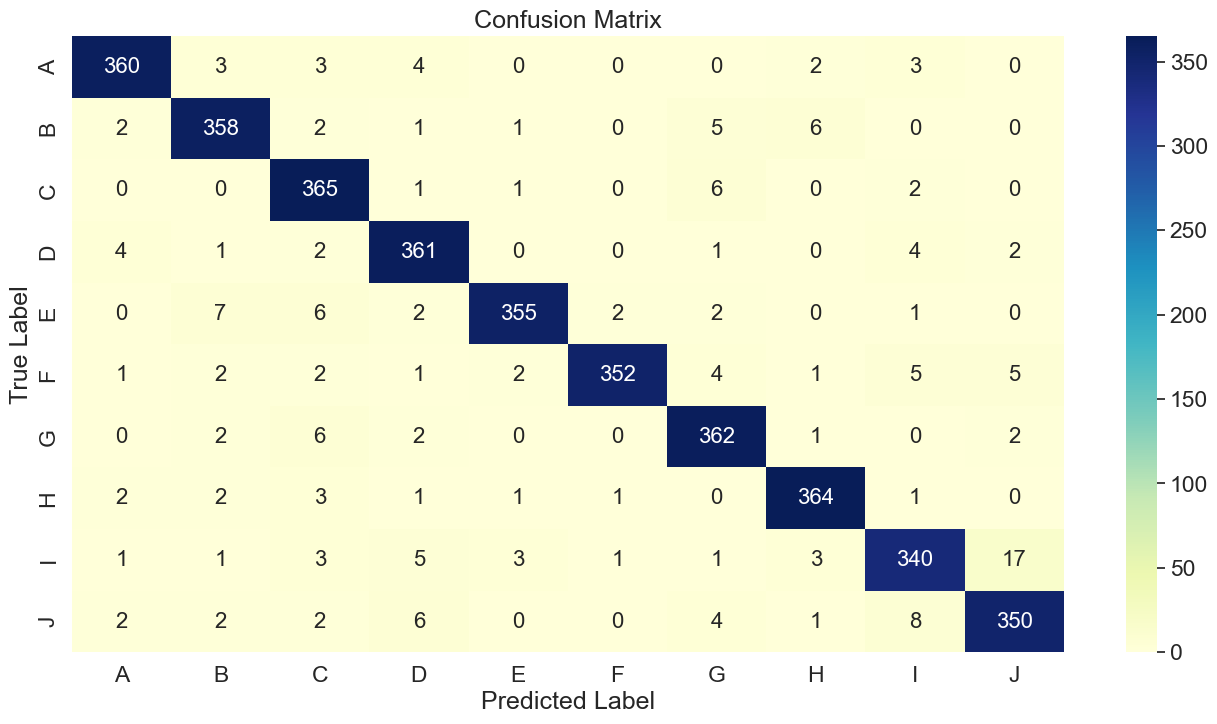

In [114]:
plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), 10)

### Affichage de l'évolution de la fonction de perte et de la précision

Visualiser l'évolution de la fonction de perte de précision au cours des epoch, à la fois pour le jeu d'entraînement et de validation, permet de voir si le modèle surajuste ou non. Si la fonction de perte sur le jeu de validation augmente alors que celle sur le jeu d'entraînement diminue, c'est que le modèle surajuste. Si les deux fonctions de perte diminuent, c'est que le modèle généralise bien. Nous pouvons également voir si le modèle converge ou non.

In [115]:
def plot_errors(history, epochs):
    epochs_range = list(range(1, epochs + 1))
    train_loss = history.history['loss']
    
    plt.figure(1, figsize=(10, 6))
    plt.plot(epochs_range, train_loss, label='train_loss')

    if history.history.get('val_loss') is not None:
        val_loss = history.history['val_loss']
        plt.plot(epochs_range, val_loss, label='val_loss')

    plt.xlabel('Epochs')
    plt.ylabel('Binary Cross Entropy')
    plt.legend()
    plt.show()

In [116]:
def plot_accurary(history, epochs):
    epochs_range = list(range(1, epochs + 1))
    train_accuracy = history.history['accuracy']

    plt.figure(1, figsize=(10, 6))
    plt.plot(epochs_range, train_accuracy, label='train_accuracy')

    if history.history.get('val_accuracy') is not None:
        val_accuracy = history.history['val_accuracy']
        plt.plot(epochs_range, val_accuracy, label='val_accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Binary Cross Entropy')
    plt.legend()
    plt.show()

On peut ainsi tracer l'évolution de la fonction de perte et de la précision en fonction des epochs.

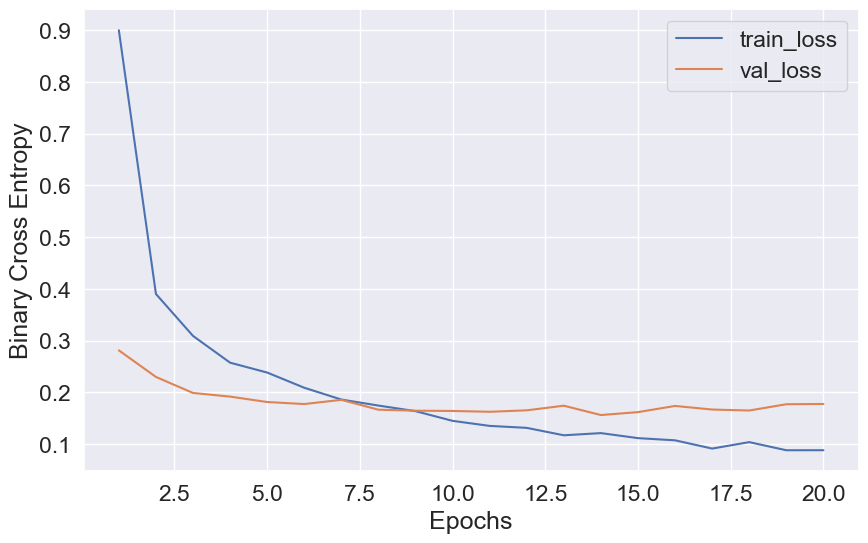

In [117]:
plot_errors(history, epochs)

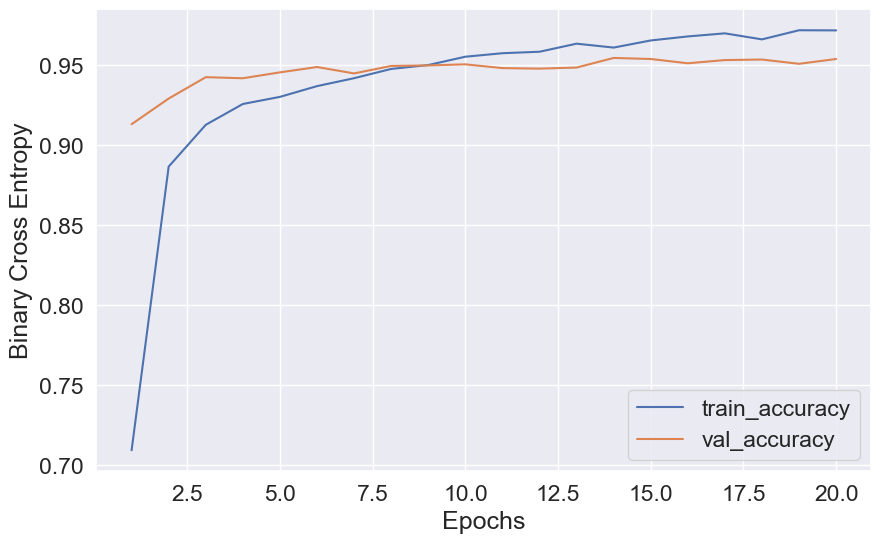

In [118]:
plot_accurary(history, epochs)

# Présentation des résultats et conclusion

Avec le modèle actuel, sans les données augmentées et avec l'entraînement qui utilise la validation croisée k-fold, nous obtenons une accuracy de 0.95 sur le jeu de test pour un loss à 0.21. Nous obtenons ce résultat avec 20 epochs et un batch size de 64.

Avec le même modèle, mais avec les données augmentées, nous obtenons une accuracy de 0.96 sur le jeu de test et 0.16 pour le loss. Nous obtenons ce résultat avec 23 epochs et un batch size de 64.

Dans les deux cas, l'accurary sur le jeu de test est très proche de celle sur le jeu d'entraînement. 

Nous pouvons conclure que l'augmentation des données, que nous avons effectuée avec un modèle GAN, permet d'améliorer les performances du modèle. Dans notre cas, cela a permis d'améliorer l'accuracy de 1% et de réduire le loss de 5%, ce qui n'est pas négligeable. On note que les données de depart, qui ne sont pas très volumineuses (moins de 2000 images par classe), ne sont pas toutes de très bonnes qualitées. Certaines images régénérées par le GAN sont églement dégradées, mais cela permet tout de même d'améliorer les performances du modèle.